1. Framework

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, DistilBertConfig
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import emoji
import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score, recall_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from torch.nn.utils.rnn import pad_sequence

2. Data Load

In [2]:
#Dataset Definition
twits_25k_path = '25k_dataset.csv'
twits_32k_path = 'hatespeech_train.csv'
#twits_150_path = ''
twits_25k_preprocessed_path = 'twits_25k_preprocessed.csv'

twits_25k = pd.read_csv(twits_25k_path)
twits_32k = pd.read_csv(twits_32k_path)
#twits_120 = pd.read_csv(twits_150_path)
twits_25k_preprocessed = pd.read_csv(twits_25k_preprocessed_path)

In [3]:
twits_25k = twits_25k[["id","class","tweet"]]
twits_25k = twits_25k.rename(columns={"class":"label"})

twits_25k_preprocessed = twits_25k_preprocessed[["id","label","tweet"]]
# twits_25k_preprocessed = twits_25k_preprocessed.rename(columns={"class":"label"})

In [4]:
twits_25k_preprocessed.head()

,id,label,tweet
0,0,2,!!! it as a woman you shouldn't complain abou...
1,1,1,!!!!! it boy days cold...tea down bad for cof...
2,2,1,!!!!!!! it dawn!!!! it you ever fuck a bitch...
3,3,1,!!!!!!!!! it she look like a tyranny
4,4,1,!!!!!!!!!!!!! it the shit you hear about me m...


In [5]:

original_dataset = twits_25k_preprocessed

# Especificar el tamaño del subconjunto que deseas
subset_size = 2000  # ajusta este valor según tus necesidades

# Obtener un subconjunto aleatorio
random_subset_25k = original_dataset.sample(n=subset_size, random_state=42)

# Ahora, random_subset contiene un subconjunto aleatorio de tu conjunto de datos


In [6]:
random_subset_25k.shape

(2000, 3)

In [17]:
def preprocess_dataset(dataset):
    # Change text to lowercase
    dataset['tweet'] = dataset['tweet'].str.lower()
    # Eliminate URLs
    dataset['tweet'] = dataset['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    # Use TextBlob for spelling correction
    dataset['tweet'] = dataset['tweet'].apply(lambda x: str(TextBlob(x).correct()))
    # Convert emojis to text and keep sentiment
    dataset['tweet'] = dataset['tweet'].apply(lambda x: emoji.demojize(x))
    # Keep hashtags
    dataset['tweet'] = dataset['tweet'].apply(lambda x: re.sub(r'#', '', x))
    # Eliminate @mentions
    dataset['tweet'] = dataset['tweet'].replace(r'@\S+', '', regex=True)
    return dataset

In [18]:
# Uso de la función con tu ruta de archivo
twits_25k_preprocessed = preprocess_dataset(twits_25k)

# Muestra las primeras filas del DataFrame resultante
print(twits_25k_preprocessed.head())

   id  label                                              tweet
0   0      2  !!! it  as a woman you shouldn't complain abou...
1   1      1  !!!!! it  boy days cold...tea down bad for cof...
2   2      1  !!!!!!! it  dawn!!!! it  you ever fuck a bitch...
3   3      1             !!!!!!!!! it   she look like a tyranny
4   4      1  !!!!!!!!!!!!! it  the shit you hear about me m...


In [19]:
twits_25k_preprocessed.to_csv("twits_25k_preprocessed.csv")

3. Prediction Number 1: DistilBERT

In [8]:
pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 977.5/977.5 kB 6.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125953 sha256=830503a1374236d0746bf41f53f1dd8147203fbca0a2b5570b4fbb3f7dd13d3b
  Stored in directory: c:\users\pablofabianfaundezga\appdata\local\pip\cache\wheels\ff\27\bf\ffba8b318b02d7f691a57084ee154e26ed24d012b0c7805881
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos

test_df = twits_25k_preprocessed

# Contar la cantidad de muestras por clase
class_counts = test_df['label'].value_counts()
# Determinar la cantidad mínima de muestras entre las clases
min_class_count = class_counts.min()
# Realizar downscaling para balancear las clases
balanced_df = pd.DataFrame()
for label in test_df['label'].unique():
    label_subset = test_df[test_df['label'] == label].sample(min_class_count, random_state=42)
    balanced_df = pd.concat([balanced_df, label_subset])

# Mezclar el dataframe resultante
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar el nuevo conjunto de datos balanceado
balanced_dataset_path = 'twits_25k_balanced.csv'
balanced_df.to_csv(balanced_dataset_path, index=False)

test_df = balanced_df

# Representaciones vectoriales de clases

class_representations = {
    '0': "This is an example of hate speech",
    '1': "This is an example of offensive language",
    '2': "This is an example that does not belong to any of the above categories."
}
# Model of text representation
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Get repr vector for each class
class_vectors = {label: model.encode([text])[0] for label, text in class_representations.items()}

# Función para predecir la clase basada en la similitud de coseno
def predict_class(text):
    text_vector = model.encode([text])[0]
    similarities = {label: np.dot(text_vector, class_vectors[label]) / (np.linalg.norm(text_vector) * np.linalg.norm(class_vectors[label])) for label in class_vectors}
    predicted_class = max(similarities, key=similarities.get)
    return predicted_class

# Realizar predicciones en el conjunto de prueba
test_df['predicted_class'] = test_df['tweet'].apply(predict_class)

# Convertir etiquetas numéricas a cadenas
test_df['label'] = test_df['label'].astype(str)
test_df['predicted_class'] = test_df['predicted_class'].astype(str)

# Calcular métricas de clasificación
accuracy = accuracy_score(test_df['label'], test_df['predicted_class'])
classification_report_str = classification_report(test_df['label'], test_df['predicted_class'])

# Mostrar resultados
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report_str)



Accuracy: 0.3713
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.65      0.47      1430
           1       0.35      0.19      0.25      1430
           2       0.40      0.27      0.32      1430

    accuracy                           0.37      4290
   macro avg       0.37      0.37      0.35      4290
weighted avg       0.37      0.37      0.35      4290



In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
# Calcular la curva ROC (Variante adaptada para clasificación por similitud)
fpr, tpr, _ = roc_curve(test_df['label'].apply(lambda x: 1 if x == '0' else 0), test_df['predicted_class'].apply(lambda x: 1 if x == '0' else 0))
roc_auc = auc(fpr, tpr)

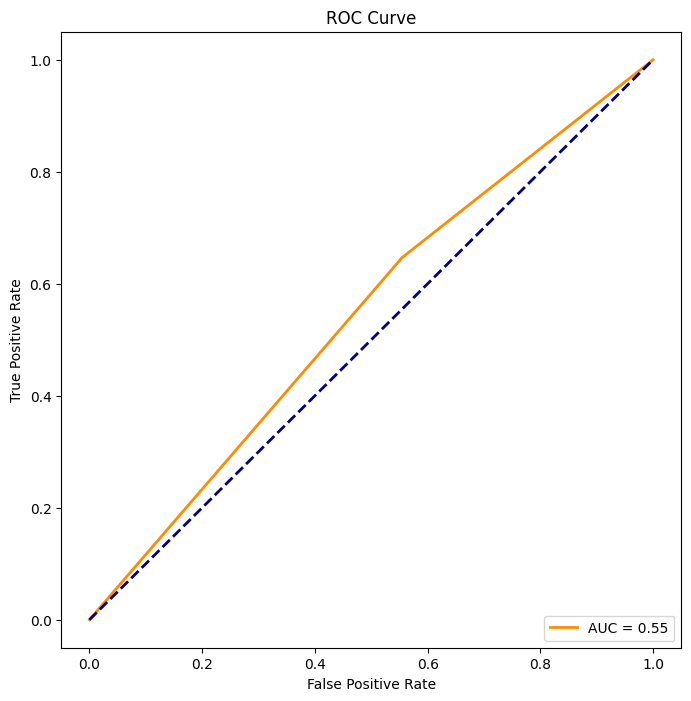

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
conf_matrix = confusion_matrix(test_df['label'], test_df['predicted_class'])
print(conf_matrix)

[[ 79  20  28]
 [929 262 359]
 [186  65  72]]


In [21]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos

test_df = random_subset_25k

# Separar datos de entrenamiento y prueba
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Representaciones vectoriales de clases
class_representations = {
    '0': "This is an example of hate speech",
    '1': "This is an example of offensive language",
    '2': "This is an example that does not belong to any of the above categories."
}

# Modelo de representación de texto RoBERTa
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Obtener representaciones vectoriales para cada clase
class_vectors = {label: tokenizer(text, return_tensors='pt')['input_ids'] for label, text in class_representations.items()}

# Función para predecir la clase basada en la similitud de coseno
def predict_class(text):
    input_ids = tokenizer(text, return_tensors='pt')['input_ids']
    with torch.no_grad():
        logits = model(input_ids)['logits']
    similarities = {label: np.dot(logits.flatten().numpy(), class_vectors[label].flatten().numpy()) / (np.linalg.norm(logits) * np.linalg.norm(class_vectors[label])) for label in class_vectors}
    predicted_class = max(similarities, key=similarities.get)
    return predicted_class


# Realizar predicciones en el conjunto de prueba
test_df['predicted_class'] = test_df['tweet'].apply(predict_class)

# Convertir etiquetas numéricas a cadenas
test_df['label'] = test_df['label'].astype(str)
test_df['predicted_class'] = test_df['predicted_class'].astype(str)

# Calcular métricas de clasificación
accuracy = accuracy_score(test_df['label'], test_df['predicted_class'])
classification_report_str = classification_report(test_df['label'], test_df['predicted_class'])

# Mostrar resultados
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report_str)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: shapes (2,) and (9,) not aligned: 2 (dim 0) != 9 (dim 0)

In [12]:
random_subset_25k['roberta'] = all_predictions_roberta

In [13]:
random_subset_25k

,id,label,tweet,roberta
2281,2326,1,934 8616\ni got a missed call from to bitch,1
15914,16283,1,it fucking with a bad bitch you gone need som...,1
18943,19362,2,"it ll my credit ain't no where near good , b...",1
16407,16780,1,it wipe the cum out of them maggot it contac...,1
13326,13654,1,nights cheat on they bitch and don't expect no...,1
...,...,...,...,...
17738,18139,1,it if you got to have every he you see you a ...,1
3015,3091,1,"birches be like.. ""it means something to me""",1
18597,19008,1,"it contrary to belief, us queer don&8217;t go...",1
17962,18365,1,"it mac 10 lay on the floor like a mattress "" ...",1


In [ ]:
# Agregar las predicciones al DataFrame
twits_25k_preprocessed['predicted_label'] = predictions


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Obtener las etiquetas reales del conjunto de datos
true_labels = twits_25k_preprocessed['label'].values

# Calcular la precisión
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy on Dataset: {accuracy:.4f}')

# Mostrar un informe de clasificación
print('Classification Report:')
print(classification_report(true_labels, predictions))

In [25]:
import os

# Ruta de la carpeta
folder_path = r'C:\Users\PabloFabianFaundezGa\Desktop\Hate Speech'

# Lista para almacenar los nombres de los archivos
file_names = []

# Recorrer los archivos en la carpeta
for file in os.listdir(folder_path):
    # Añadir el nombre del archivo a la lista
    file_names.append(file)

# Imprimir la lista de nombres de archivos
print(file_names)


['25k_dataset.csv', 'app.py', 'bayesnaiveclass.ipynb', 'hatespeech_train.csv', 'index.html', 'modelling.ipynb', 'naive_bayes_model.pkl', 'notebook1c20a1fb3f.ipynb', 'one_vs_rest_classifier.pkl', 'palestine_hatespeech.ipynb', 'prepared_hatespeech_train.csv', 'result.html', 'test_dataset.csv', 'train_dataset.csv', 'twits_25k_balanced.csv', 'twits_25k_preprocessed.csv', 'vectorizer.pkl']
